In [1]:
import os
import cv2
import numpy as np
import mediapipe as mp
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Attention, Input, Conv1D
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

2025-04-08 11:48:24.131213: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744080504.146322   59136 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744080504.152124   59136 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744080504.164108   59136 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744080504.164124   59136 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744080504.164125   59136 computation_placer.cc:177] computation placer alr

In [2]:
import pickle
import os

# pickle : sequence 데이터 30개
# pickle_2 : x, y
# pickle_3 : x, y + 각도

pickle_dir = '/home/shin/deeplearning-repo-1/faa_model/pickle/'

dataset = []
labels = []
for file in os.listdir(pickle_dir):
    if file.endswith('.pkl'):
        with open(os.path.join(pickle_dir, file), 'rb') as f:
            data, label = pickle.load(f)
            dataset.extend(data)
            labels.extend(label)
            print(file, len(data))

프론트 런지.pkl 4276
스탠딩 니업.pkl 9208
스쿼트.pkl 10542
숄더프레스.pkl 3041


In [3]:
X = np.array(dataset)
y = np.array(to_categorical(labels))

X.shape, y.shape

((27067, 30, 24), (27067, 4))

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

In [192]:
early_stopping = EarlyStopping(
    monitor='loss',      # loss를 모니터링
    patience=5,         # 10 epoch 동안 개선 없으면 멈춤
    restore_best_weights=True # 가장 좋은 가중치 복원
)

model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.3))
model.add(LSTM(64, return_sequences=False, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dense(y.shape[1], activation='softmax'))

# inputs = Input(shape=(X.shape[1], X.shape[2]))
# x = LSTM(64, return_sequences=True)(inputs)
# dropout = Dropout(0.3)(x)
# attention = Attention()([dropout, dropout])
# x = LSTM(64)(attention)
# dropout = Dropout(0.3)(x)
# x = Dense(64, activation="relu")(dropout)
# x = Dense(32, activation="relu")(x)
# outputs = Dense(y.shape[1], activation="softmax")(x)

# model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/home/shin/venv/project/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [193]:
# hist = model.fit(X_train, y_train, epochs=50, batch_size=100, callbacks=[early_stopping], validation_data=(X_val, y_val))
hist = model.fit(X_train, y_train, epochs=20, batch_size=100, validation_data=(X_val, y_val))

Epoch 1/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5515 - loss: 0.9704 - val_accuracy: 0.8907 - val_loss: 0.3307
Epoch 2/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9109 - loss: 0.2851 - val_accuracy: 0.9644 - val_loss: 0.1235
Epoch 3/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9539 - loss: 0.1476 - val_accuracy: 0.9668 - val_loss: 0.0905
Epoch 4/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9709 - loss: 0.0779 - val_accuracy: 0.9906 - val_loss: 0.0262
Epoch 5/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9813 - loss: 0.0485 - val_accuracy: 0.9909 - val_loss: 0.0266
Epoch 6/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9846 - loss: 0.0395 - val_accuracy: 0.8899 - val_loss: 0.2142
Epoch 7/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9632 - loss: 0.0867 - val_accuracy: 0.9935 - val_loss: 0.0156
Epoch 8/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9908 - loss: 0.0275 - val_accuracy: 0.

In [194]:
model.save('exercise_classifier_2.h5')

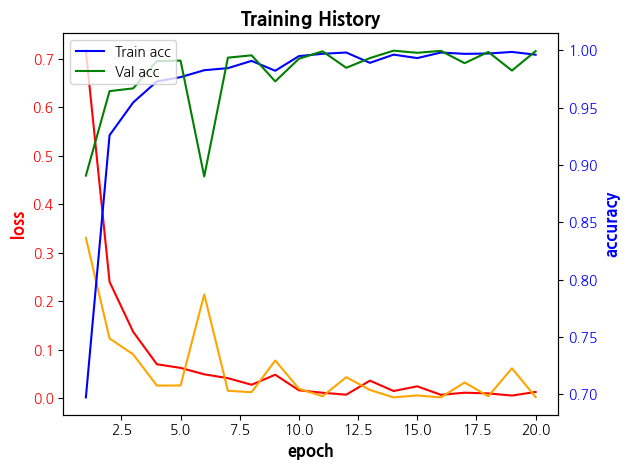

In [195]:
import matplotlib.pyplot as plt

# 데이터 추출
loss = hist.history['loss']
val_loss = hist.history['val_loss']
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
epochs = range(1, len(loss) + 1)

fig, ax1 = plt.subplots()

# 왼쪽 Y축 (loss)
ax1.plot(epochs, loss, color='red', label='Train loss')
ax1.plot(epochs, val_loss, color='orange', label='Val loss')
ax1.set_xlabel('epoch', fontsize=12, weight='bold')
ax1.set_ylabel('loss', color='red', fontsize=12, weight='bold')
ax1.tick_params(axis='y', labelcolor='red')

# 오른쪽 Y축 (accuracy)
ax2 = ax1.twinx()
ax2.plot(epochs, acc, color='blue', label='Train acc')
ax2.plot(epochs, val_acc, color='green', label='Val acc')
ax2.set_ylabel('accuracy', color='blue', fontsize=12, weight='bold')
ax2.tick_params(axis='y', labelcolor='blue')

fig.patch.set_alpha(0)     # figure 배경 투명
ax1.patch.set_alpha(0)      # plot 영역 배경 투명

# 범례
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(lines_2, labels_2, loc='upper left')

# 제목 및 여백
plt.title('Training History', fontsize=14, weight='bold')
plt.tight_layout()
plt.show()


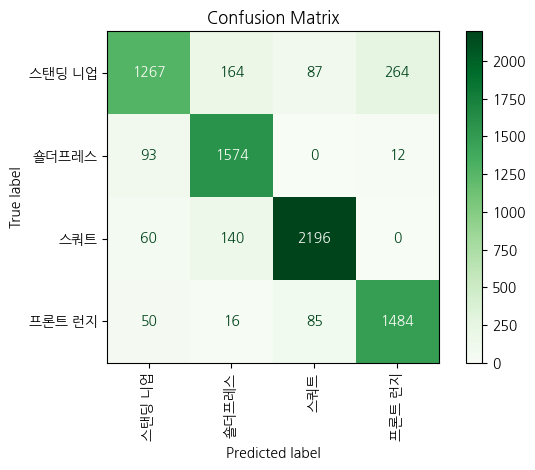

In [196]:
import pickle
import os
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import koreanize_matplotlib
from tensorflow.keras.models import load_model

dataset = []
labels = []

pkl_path = "/home/shin/deeplearning-repo-1/faa_model/valid_pickle_2/"
model_path = "exercise_classifier_2.h5"
label_names = ["스탠딩 니업", "숄더프레스", "스쿼트", "프론트 런지"]

# 데이터 로드
for file in os.listdir(pkl_path):
    if file.endswith('.pkl'):   
        with open(os.path.join(pkl_path, file), 'rb') as f:
            data, label = pickle.load(f)
            dataset.extend(data)
            labels.extend(label)

X = np.array(dataset) 
y_true = np.array(labels)

model = load_model(model_path)
y_pred = np.argmax(model.predict(X, verbose=0), axis=1)

fig, ax = plt.subplots()
cm = confusion_matrix(y_true, y_pred, labels=range(len(label_names)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(ax=ax, cmap='Greens', xticks_rotation=90)
fig.patch.set_alpha(0)     # figure 배경 투명
ax.patch.set_alpha(0)      # plot 영역 배경 투명
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


In [197]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=label_names, digits=4))

              precision    recall  f1-score   support

      스탠딩 니업     0.8619    0.7110    0.7792      1782
       숄더프레스     0.8310    0.9375    0.8811      1679
         스쿼트     0.9274    0.9165    0.9219      2396
      프론트 런지     0.8432    0.9076    0.8742      1635

    accuracy                         0.8704      7492
   macro avg     0.8659    0.8682    0.8641      7492
weighted avg     0.8718    0.8704    0.8684      7492

